In [2]:
import numpy as np
import pandas as pd
import logging
import os
import sys

log = lambda msg: logging.info(msg)

root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))
sys.path.append(root_dir)


# Load data

In [8]:
import sleep_events
from importlib import reload
reload(sleep_events)
from sleep_events import load_days_data

day_data = load_days_data(True)

AttributeError: module 'zstandard' has no attribute '__version__'

In [1]:
[col for col in day_data if "deep" in col]

NameError: name 'day_data' is not defined

In [36]:
target_features = [col for col in day_data if "energy" in col]
target_features = [['energy:justEnergy:manualDayEnergyScoreStartToEvening', [col for col in day_data if "energy" in col]]]

In [40]:
import sys
from importlib import reload
import models.util.day_data_level_features
reload(models.util.day_data_level_features)


import day_features_predict_all_features
reload(day_features_predict_all_features)

from models.final_wake.final_wake_model import ModelAndData
from sklearn.model_selection import train_test_split
import memory
from models.util.rfe_training import train_rfe
from models.util.evaluation import evaluate_regression_model_quick

# models = []

results = []
errors = []

def split(modelAndData: ModelAndData):
    X_train_to_sleep, X_val_to_sleep, y_train_to_sleep, y_val_to_sleep = train_test_split(modelAndData.X, modelAndData.y, test_size=0.2, random_state=42)
    modelAndData.X_train = X_train_to_sleep
    modelAndData.y_train = y_train_to_sleep
    modelAndData.X_val = X_val_to_sleep
    modelAndData.y_val = y_val_to_sleep

models_and_data = []

for tf in target_features:
    target_feature = tf[0]
    remove_cols = [c for c in tf[1] if c != target_feature]
    models_and_data.extend(day_features_predict_all_features.create_and_add_all(day_data, target_feature, False, remove_cols))
    
for md in models_and_data:
    split(md)


CleanTargetCol (324, 2751) to (88, 2751)
Condition (88, 2751) to (88, 2751)
DayDataFeaturesHandler (88, 2734) to (88, 2294), first index 0
RequireNonEmptyRows (88, 2294) to (88, 2294)
DropBadRows (88, 2294) to (88, 2294)


# Train XGBoost model

In [52]:
from models.util.rfe_training import train_rfe
from models.util.evaluation import evaluate_regression_model_quick
from dataclasses import dataclass
import xgboost as xgb
from sklearn.feature_selection import RFE
import models.util.importances as importances
from importlib import reload
reload(importances)
import models.util.rfe_training as training
reload(training)


train_list = []
# train_list.append({"type": "XGBoost+HSTreeClassifierCV", "requireRemovedNan": True})
# train_list.append({"type": "ExplainableBoostingClassifier"})
train_list.append({"type": "ExplainableBoostingRegressor"})
# train_list.append({"type": "FIGSRegressor", "rfe": False, "requireRemovedNan": True})
# train_list.append({"type": "XGBoostRegressor", "rfe": True, "supportsFeatureWeights": True})


for md in models_and_data:
    for tl in train_list:
        md.models = train_rfe(training.get_model, tl, md.name, md.X_train, md.y_train, md.X_val, md.y_val, do_rfe=False)




import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)

evaluation.evaluate_regression_models(models_and_data)



Training ExplainableBoostingRegressor model for energy:justEnergy:manualDayEnergyScoreStartToEvening with (70, 2293)

c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\interpret\utils\_preprocessor.py:314: RuntimeWarning: All-NaN slice encountered
  min_feature_val = np.nanmin(X_col)
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\interpret\utils\_preprocessor.py:315: RuntimeWarning: All-NaN slice encountered
  max_feature_val = np.nanmax(X_col)
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\interpret\glassbox\_ebm\_ebm.py:669: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]
  warn(


... RMSE train: 5.917029725126459 RMSE val: 11.460361823996728


,MAE_Train,MAE_Val,RMSE_Train,RMSE_Val,Rows_Train,Model,MdIdx,MsIdx,n_features,source,requiresNumpy,isClassifier
0,4.438591,9.813588,5.91703,11.460362,70,energy:justEnergy:manualDayEnergyScoreStartToE...,0,0,2293,ExplainableBoostingRegressor,False,False


In [53]:
bm = models_and_data[0].models[0]

In [56]:
from interpret import show

show(bm.model.explain_global())

c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\dash\_jupyter.py:31: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  _dash_comm = Comm(target_name="dash")
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\interpret\visual\_udash.py:117: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



<!-- http://127.0.0.1:7001/1702192358080/ -->

Evaluation for model:  energy:justEnergy:manualDayEnergyScoreStartToEvening
energy:justEnergy:manualDayEnergyScoreStartToEvening Training Set Evaluation:
MAE: 0.0006198175307572638, MSE: 8.104610196739872e-07, RMSE: 0.0009002560856078604
energy:justEnergy:manualDayEnergyScoreStartToEvening Validation Set Evaluation:
MAE: 11.054118682111717, MSE: 187.45120510356642, RMSE: 13.691282083996605


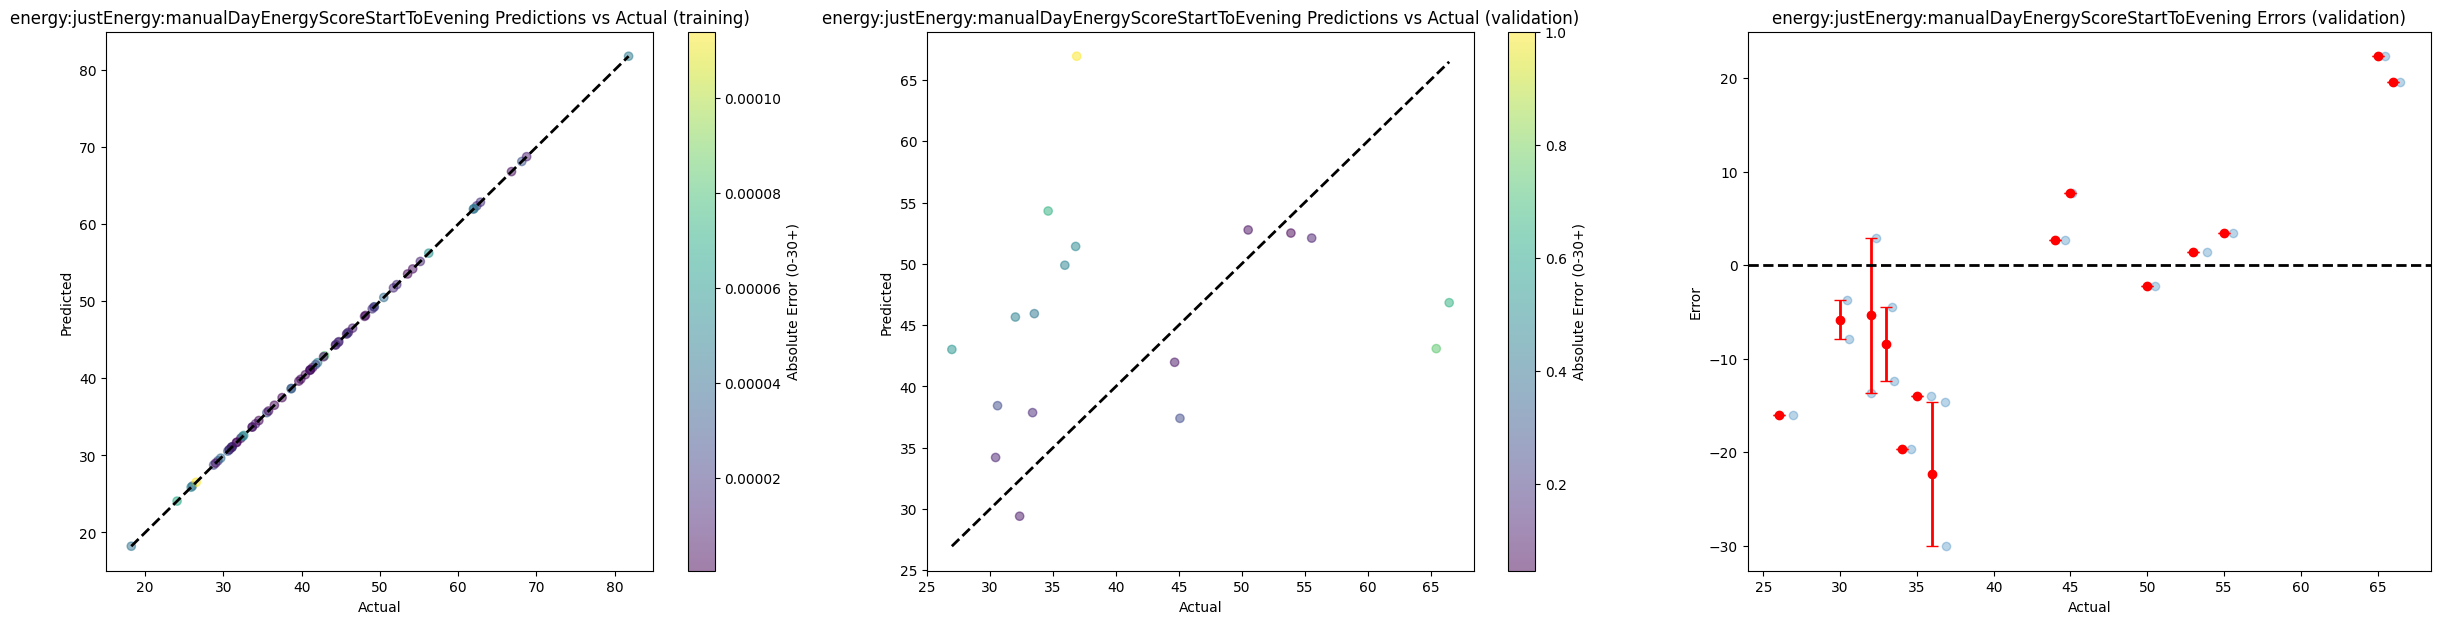

In [47]:
import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)

evaluation.evaluate_model(bm.model, bm.name, bm.X_train, bm.y_train, bm.X_val, bm.y_val, bm.is_classifier)

# Most useful features

In [ ]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

# Plot the 0th tree
#xgb.to_graphviz(bst, num_trees=1)
# plt.show()


In [48]:
# Install SHAP if you haven't already
# !pip install shap

import shap
import xgboost as xgb

# Create a DMatrix for SHAP
# dmatrix = xgb.DMatrix(bm.X_train)

# Initialize the SHAP explainer
explainer = shap.Explainer(bm.model)

# Calculate SHAP values
shap_values = explainer(bm.X_train)

shap_values.shape

(70, 8)

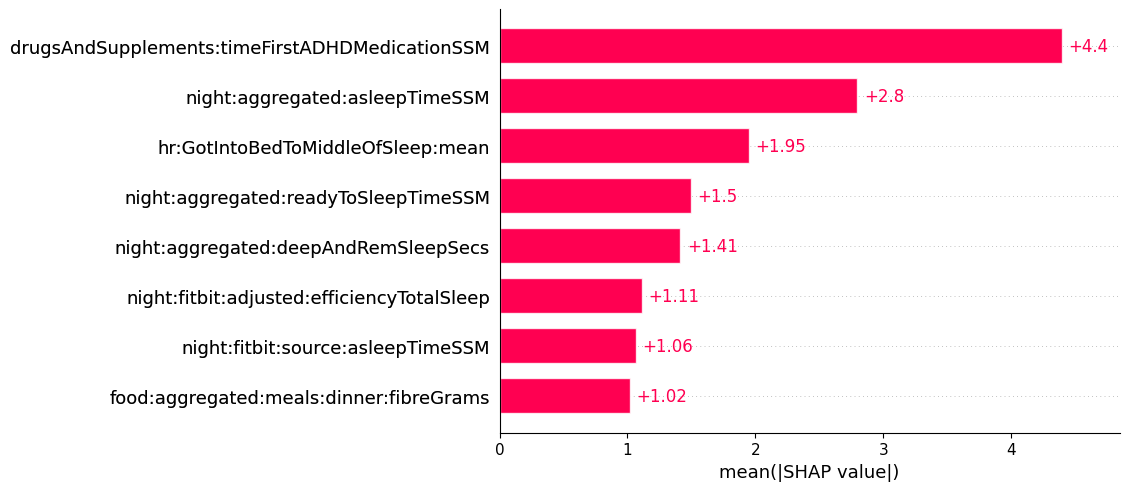

In [49]:
shap.plots.bar(shap_values, max_display=20)


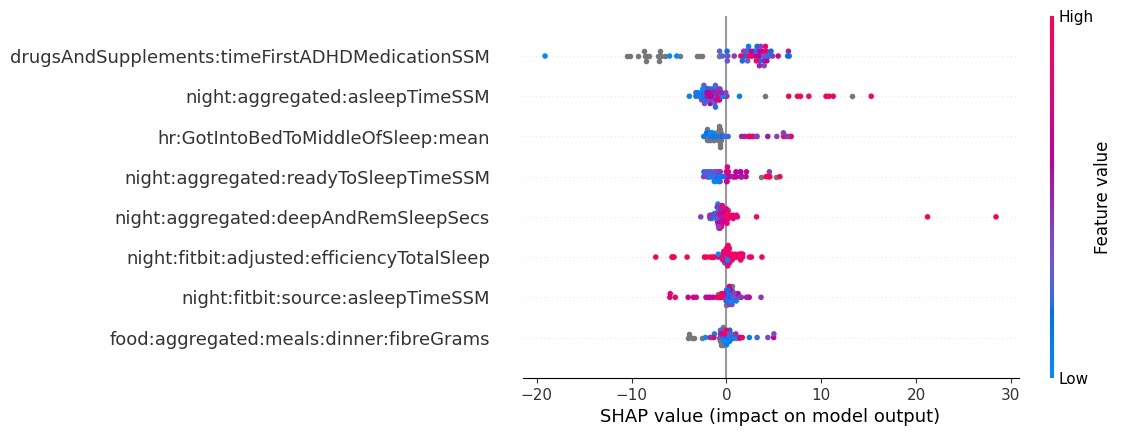

In [50]:
shap.plots.beeswarm(shap_values, max_display=20)


In [57]:
# Calculate the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

# Get the indices of the top 16 features
top_features_indices = np.argsort(mean_abs_shap_values)[-16:][::-1]

# Get the names of the top 16 features
top_features = [shap_values.feature_names[i] for i in top_features_indices]

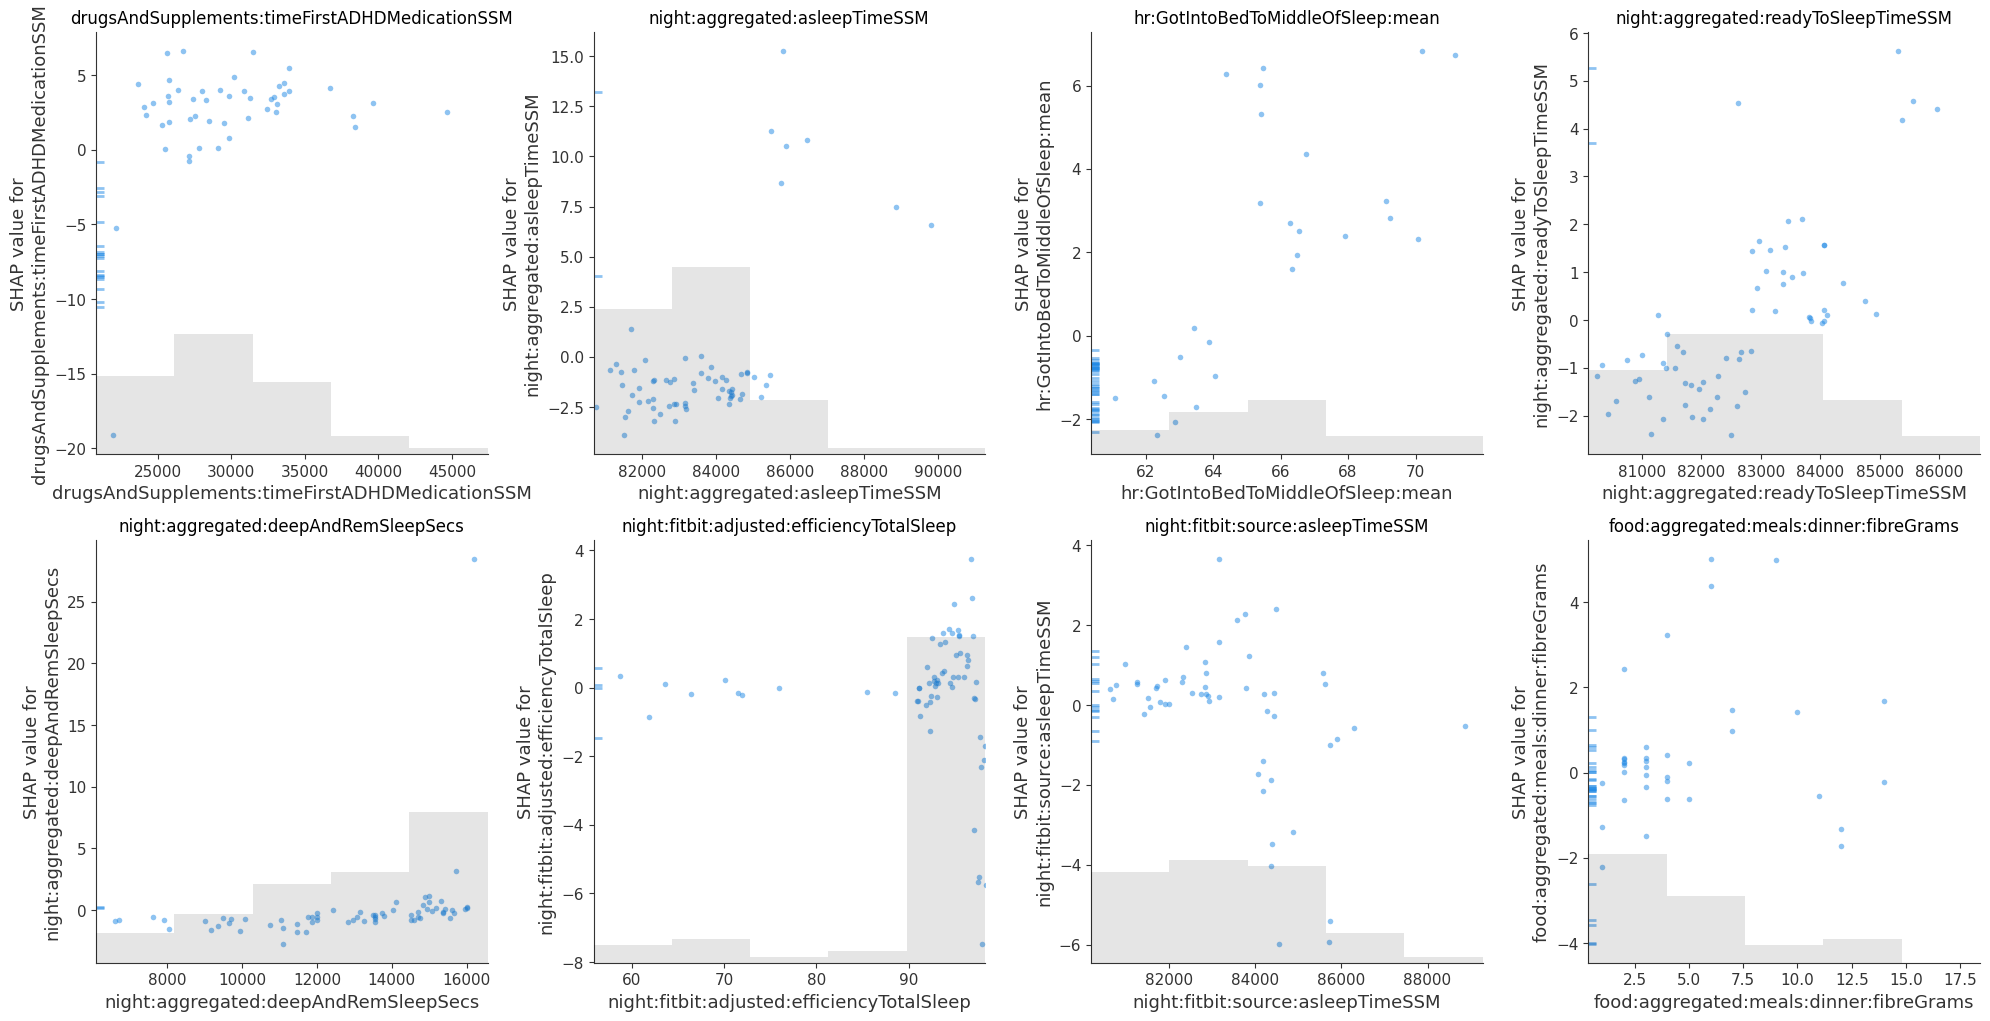

In [58]:
import matplotlib.pyplot as plt
import shap

# Create a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(top_features):
    shap.plots.scatter(shap_values[:, feature], ax=axes[i], show=False, xmin='percentile(1)', xmax='percentile(99)', alpha=0.5)  # Avoid triggering plt.show()
    axes[i].set_title(feature)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
